This notebook is based on Yassine Ghouzam's [Introduction to CNN Keras](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

np.random.seed(2)

# Data Preparation

I import the data from the MNIST database. I reshape the images to add a the channel (i.e. the number of colors in the image, here one) and I normalize the elements of the matrices (by dividing by the difference between the maximum and the minimum element).

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(path='mnist.npz')
X_train = X_train.reshape(-1,28,28,1) # -1 means the value is inferred from the length of the array and remaining dimensions.
X_test = X_test.reshape(-1,28,28,1)
X_train = X_train/255
X_test = X_test/255
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


I convert the label vector to a matrix of one-hot vectors. The columns correspond to the possible digit that the image can represent. Each row is filled with zeros but for one element which is one, indicating the label of the image.

In [3]:
Y_train = to_categorical(Y_train, num_classes = 10)

I split the training set in training and validation, where 1/10 of the initial set constitutes the validation set.
I set a seed in order to assure that this random split is reproducible.

In [4]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

# Model

The architecture of the model is as follows:

\[\([2D Convolution](https://keras.io/api/layers/convolution_layers/convolution2d/)\) x 2 &#8594; [2D Max Pooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/) &#8594; [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)\] x 2 &#8594; [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) &#8594; [Dense](https://keras.io/api/layers/core_layers/dense/) &#8594; [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) &#8594; [Out](https://keras.io/api/layers/core_layers/dense/)

__Conceptual Summary of the Architecture:__

* Convolutional Layer: Abstracts a feature map from an image.
* Max Pooling Layer: Summarizes the most activated presence of a feature.
* Dropout Layer: Randomly sets a fraction of input units to 0 at each training step.
* Flatten Layer: Flattens input into a vector.
* Dense Layer: Fully connected layer, i.e. all neurons between two layers are interconnected.

A “Kernel” refers to a 2D array of weights. The term “filter” is for 3D structures of multiple kernels stacked together. For a 2D filter, filter is same as kernel. But for a 3D filter and most convolutions in deep learning, a filter is a collection of kernels.

__Summary of the TensorFlow's Arguments:__

* Filters: Dimensionality of the output space, i.e. number of features to extract from the input.
* Kernel Size: Height and width of the 2D convolution window.
* Padding:
    - Valid = No padding.
    - Same = Even zero padding of the input such that output has the same dimensions as the input.
* Activation:
    - Main Advantage of ReLu in CNN Context: Prevents exponential growth in computation. As the CNN scales in size, the computational cost of adding extra ReLUs increases linearly.
    - Main Advantage of Softmax in Output Context: Ensuring that the sum of the final activations (logits) is equal to one. These logits can then be interpreted as probabilities and used for classification.
* Pool Size: Height and width of the 2D pool window.
* Stride: Controls how the convolution window moves around the input.

In [5]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

[ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) reduces the learning rate as the monitored metric stagnated for _patience_ epochs.  
&#8594; Prevents divergent behaviour from minimum if learning rate too high.

[ImageDataGenerator](https://keras.io/api/preprocessing/image/) generates noisier images from the training set.  
&#8594; Reduces overfitting.


In [6]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) 
epochs = 30
batch_size = 86

In [7]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

Epoch 1/30
627/627 - 216s - loss: 0.3478 - accuracy: 0.8883 - val_loss: 0.0592 - val_accuracy: 0.9833
Epoch 2/30
627/627 - 216s - loss: 0.1049 - accuracy: 0.9689 - val_loss: 0.0341 - val_accuracy: 0.9882
Epoch 3/30
627/627 - 148s - loss: 0.0804 - accuracy: 0.9760 - val_loss: 0.0391 - val_accuracy: 0.9888
Epoch 4/30
627/627 - 136s - loss: 0.0715 - accuracy: 0.9794 - val_loss: 0.0450 - val_accuracy: 0.9863
Epoch 5/30
627/627 - 138s - loss: 0.0667 - accuracy: 0.9810 - val_loss: 0.0282 - val_accuracy: 0.9917
Epoch 6/30
627/627 - 136s - loss: 0.0633 - accuracy: 0.9816 - val_loss: 0.0306 - val_accuracy: 0.9908
Epoch 7/30
627/627 - 137s - loss: 0.0597 - accuracy: 0.9829 - val_loss: 0.0400 - val_accuracy: 0.9897
Epoch 8/30
627/627 - 136s - loss: 0.0637 - accuracy: 0.9825 - val_loss: 0.0336 - val_accuracy: 0.9920
Epoch 9/30
627/627 - 136s - loss: 0.0612 - accuracy: 0.9828 - val_loss: 0.0267 - val_accuracy: 0.9930
Epoch 10/30
627/627 - 135s - loss: 0.0643 - accuracy: 0.9828 - val_loss: 0.0298 - 

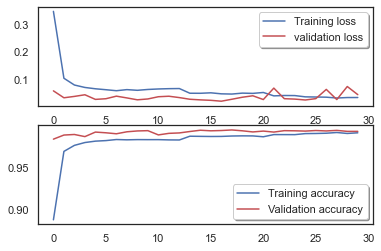

In [8]:
datagen.fit(X_train)
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [26]:
results = model.predict(X_test)
results = np.argmax(results, axis = 1)
print('Accuracy:', (Y_test==results).sum()/len(Y_test))

Accuracy: 0.9948
